In [1]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Converts `SavedModel` to TensorRT graph and measures inference time.

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
from absl import app
from absl import flags
import requests
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
#import tensorrt as trt
from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model import tag_constants

import IPython.display as Disp
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# image_url = 'https://tensorflow.org/images/blogs/serving/cat.jpg'
saved_model_dir = 'epoch26_inference.pb'
model_input = ['input_1:0']
model_output = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0',
               'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0',
               'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']

#### loading original tensorflow model

In [5]:
# detection_graph = tf.Graph()
# with detection_graph.as_default():
#     od_graph_def = tf.GraphDef()
#     with tf.gfile.GFile('tensorrt_model_testing/saved_model.pb', 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.import_graph_def(od_graph_def, name='')

In [5]:
def get_graph(frozen_model_file):
    with tf.gfile.GFile(frozen_model_file,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### converting to tensorrt graph

In [7]:
precision = "FP16"
batch_size=1
workspace_size=1 << 30
trt_graph = trt.create_inference_graph(get_graph(saved_model_dir),model_output,\
                                       precision_mode=precision,max_workspace_size_bytes=workspace_size,\
                                      max_batch_size=batch_size,is_dynamic_op=True)

with tf.gfile.GFile(saved_model_dir.replace('.pb','_trt.pb'),'wb') as f:
    f.write(trt_graph.SerializeToString())

In [8]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in get_graph(saved_model_dir).node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 2003
numb. of trt_engine_nodes in TensorRT graph: 7
numb. of all_nodes in TensorRT graph: 995


#### on anaconda trt
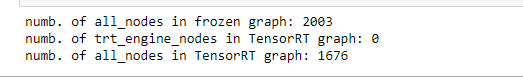

In [9]:
trt_detection_graph = tf.Graph()

with trt_detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    tf.import_graph_def(trt_graph,name='')

#### saving tensorrt graph

In [ ]:
with trt_detection_graph.as_default():
    with tf.Session(graph=trt_detection_graph) as sess:
        tf.train.write_graph(sess.graph,
                         'tensorrt_model_testing','tensorrt_model_epoch26.pb', as_text=True)

#### normal graph

In [6]:
video_url = '/home/prateek/Desktop/Video_Data/Video/5.In_front_of_engineering/Camera16_spandan office_spandan office_20181219102846_20181219102859_591291.mp4'
video_url = 0
trt_graph = get_graph('epoch26_inference_trt.pb')
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.8)
fps = []
graph = tf.Graph()    
#cap = cv2.VideoCapture(0)
image = plt.imread('test_img.jpg')
image_res = cv2.resize(image,(640,480))
image_np_expanded = np.expand_dims(image_res,axis=0)
with graph.as_default():
    with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options) ) as sess:
        tf.import_graph_def(trt_graph, name='')
        while True:
            Disp.clear_output(wait=True)
#             ret,image = cap.read()
#             if not ret:
#                 break
#             draw = image.copy()
#             draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

            # process image
            start = time.time()
            
            image_tensor = graph.get_tensor_by_name('input_1:0')
            op = sess.run(model_output,feed_dict={
                                image_tensor: image_np_expanded})    
            print("FPS = ",1/(time.time()-start))
            
                
            

     

KeyboardInterrupt: 

In [ ]:
# cap = cv2.VideoCapture(0)
# with trt_detection_graph.as_default():
    
#     with tf.Session(graph=trt_detection_graph) as sess:
#         while True:
#             Disp.clear_output(wait=True)
#             for i in range(1):
#                 ret,image  = cap.read()
#             draw = image.copy()
#             draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

#             # process image
#             start = time.time()
#             op = sess.run(model_output,feed_dict={
#                                 model_input: [image]})

#             #(boxes, scores, labels) = sess.run([boxes, scores,labels],feed_dict={image_tensor: image_np_expanded})
#             print("FPS = ",1/(time.time()-start))
# cap.release()

In [8]:
cap.release()